# IMaGES on ROI time series

In [1]:
import os
from os.path import join as pjoin
import glob
import pandas as pd
import numpy as np
import pydot
from IPython.display import SVG
import matplotlib.pyplot as plt
from matplotlib import pyplot, patches
from pycausal import pycausal as pc
from pycausal import search as s
import networkx as nx
from networkx.drawing import nx_pydot
import itertools

In [2]:
%matplotlib inline

In [3]:
def getdfs(csvdir):
    """give us list of data frames for csv files in directory"""
    dfs = []
    for csvfile in glob.glob(csvdir_allruns + os.sep + "*.csv"):
        df = pd.read_csv(csvfile)
        dfs.append(df)
    return dfs

## Preprocessed BOLD data

In [4]:
# directory with csv files for roi time series (seperate csv file for each run)
csvdir_allruns = pjoin('/host', 'famfaces', 'extract_meants', 'csv', 'allruns')
dfs = getdfs(csvdir_allruns)

In [5]:
# perform images search
pc.start_vm() # start
images = s.imagesSemBic(dfs, verbose = True)
pc.stop_vm() # stop

In [6]:
# show nodes
# images.getNodes()

In [7]:
# show edges
# images.getEdges()

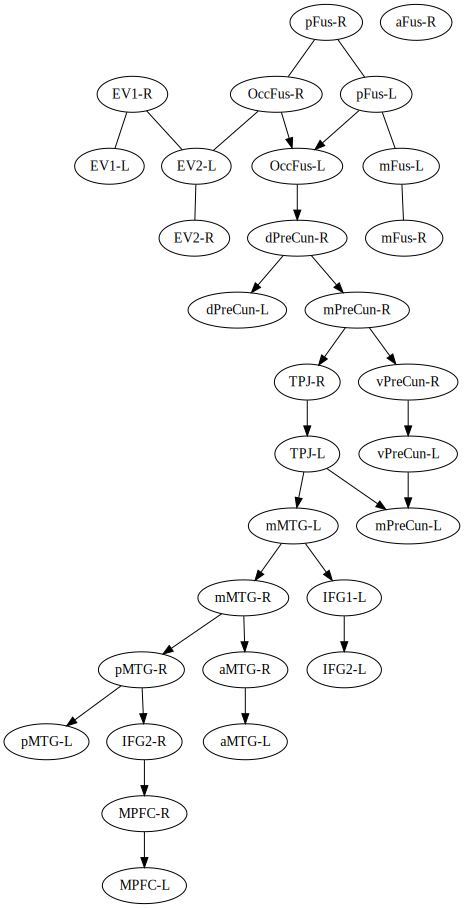

In [8]:
# render resulting graph
dot = images.getDot()
svg_str = dot.create_svg(prog='dot')
SVG(svg_str)

## Residuals

From a nuisance model with motion parameters, outliers, and button press as regressors.

In [9]:
# nuisance data with button press
dfs_nb = getdfs(pjoin('/host', 'famfaces', 'extract_meants_nuisance_button', 'csv', 'run*'))

In [10]:
# perform images search
pc.start_vm() # start
images_nb = s.imagesSemBic(dfs_nb, verbose = True)
pc.stop_vm() # stop

In [11]:
# nodes and edges
# images_nb.getNodes()
# images_nb.getEdges()  

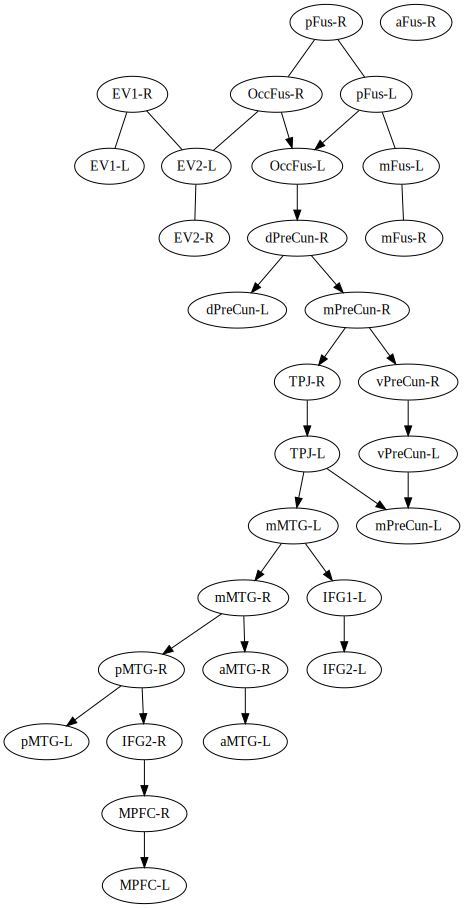

In [12]:
# render resulting graph
dot_nb = images_nb.getDot()
SVG(dot_nb.create_svg(prog='dot'))

# extract adjacencies from images object *manually*

In [13]:
def splitpair(pair):
    """
    split string containing two nodes into a tuple of two nodes.
    ignore directedness of connection.
    Used in get_adjacencies.
    """
    split = tuple([label.replace('- ', '').replace('> ', '').replace(' ', '') # looks ugly, but is supposedly faster
                   for label in pair.split('--')])
    return split

In [14]:
def get_adjacencies(images_instance):
    """
    returns a list of tuples of connected nodes
    """
    
    # get edges and convert from unicode to string
    images_edges = images_instance.edges
    edgestrings = [str(edge) for edge in images_edges]
    
    # split the strings to get tuples, turn into arrays and sort
    edges = np.array([splitpair(pair) for pair in edgestrings])
    connections = edges[np.argsort(edges[:, 0])]
    
    return connections

**TODO:** Very important! Assert that the length of all arrays is 30, when I start comparing them. Also, be sure that the order of the ROIs is exactly the same in each instance. To do so, save the first extracted connection arrays as a template and compare all following ones, wether the first column is identical to the template.

In [119]:
# apply above functions and inspect results
connections = get_adjacencies(images_nb)
print('shape of adjacency array: ' + str(np.shape(connections)) + '\n')
print(connections)

shape of adjacency array: (30, 2)

[['EV1-R' 'EV2-L']
 ['EV1-R' 'EV1-L']
 ['EV2-L' 'EV2-R']
 ['IFG1-L' 'IFG2-L']
 ['IFG2-R' 'MPFC-R']
 ['MPFC-R' 'MPFC-L']
 ['OccFus-L' 'dPreCun-R']
 ['OccFus-R' 'EV2-L']
 ['OccFus-R' 'OccFus-L']
 ['TPJ-L' 'mPreCun-L']
 ['TPJ-L' 'mMTG-L']
 ['TPJ-R' 'TPJ-L']
 ['aMTG-R' 'aMTG-L']
 ['dPreCun-R' 'dPreCun-L']
 ['dPreCun-R' 'mPreCun-R']
 ['mFus-L' 'mFus-R']
 ['mMTG-L' 'mMTG-R']
 ['mMTG-L' 'IFG1-L']
 ['mMTG-R' 'pMTG-R']
 ['mMTG-R' 'aMTG-R']
 ['mPreCun-R' 'vPreCun-R']
 ['mPreCun-R' 'TPJ-R']
 ['pFus-L' 'OccFus-L']
 ['pFus-L' 'mFus-L']
 ['pFus-R' 'OccFus-R']
 ['pFus-R' 'pFus-L']
 ['pMTG-R' 'pMTG-L']
 ['pMTG-R' 'IFG2-R']
 ['vPreCun-L' 'mPreCun-L']
 ['vPreCun-R' 'vPreCun-L']]


In [16]:
# get nodes in string format (instead of unicode)
# actually I don't think I need that.
# nodes = [str(node) for node in images_nb.nodes]

Create zero-array with shape 30x30. for row in rows: Look up index i of second element in first column. Fill i-th column of row with a 1.

In [17]:
zeros = np.zeros(shape=(30,30))
np.shape(zeros)

(30, 30)

In [18]:
adjacency_matrix = np.array([np.isin(connections[:,0], row[1]).astype(int) for row in connections])
np.shape(adjacency_matrix)

(30, 30)

# to networkx

**Problems with networkx**

I suspect that when loading the pydot from images into networkx, some things go wrong:

1) all connections are directed (see graph visualization below)

2) This leads to an adjacency matrix that is asymmetrical and more sparse

3) I suspect this is because networkx has no object for graphs with both directed and undirected edges

In [169]:
# switch from images.pydot to nx graph
graph_raw = nx_pydot.from_pydot(dot)
graph_nb = nx_pydot.from_pydot(dot_nb)

# check if the nx adj matrix is identical to the one we extracted manually
from_nx = nx.to_numpy_matrix(graph_nb)
from_nx == adjacency_matrix

matrix([[ True, False, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True],
        [ True,  True,  True, False,  True,  True,  True,  True, False,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True],
        [ Tr

In [167]:
def get_sorted_matrix_nx(G):
    node_order = sorted(G.nodes())
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)
    return adjacency_matrix

In [170]:
testmatrix = get_sorted_matrix_nx(graph_nb)
#testmatrix

## make graph undirected

In [173]:
und_nb = graph_nb.to_undirected()

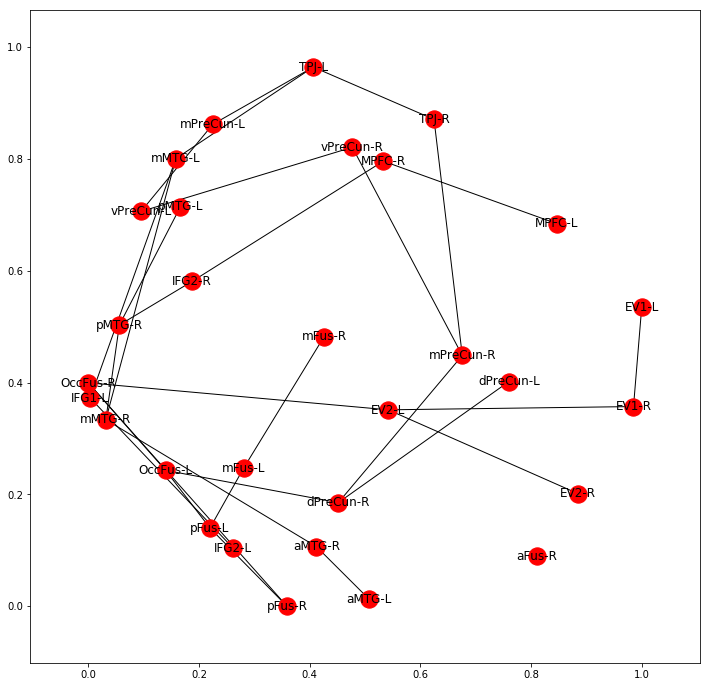

In [174]:
positions=nx.spring_layout(graph_nb,iterations=30)
plt.figure(figsize=(12,12)) 
nx.draw_networkx(und_nb, pos=positions)
plt.show()

In [178]:
# adjacency matrix of the new undirected graph
am_und = get_sorted_matrix_nx(und_nb)
# am_und

Now, is this the same as the matrix I extracted manually earlier? (answer: no)

In [179]:
# am_und == adjacency_matrix

# plot adjacency matrix

In [147]:
def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[], figsz=(5,5)):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    
    adapted from: http://sociograph.blogspot.de/2012/11/visualizing-adjacency-matrices-in-python.html
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = pyplot.figure(figsize=figsz) # in inches
    pyplot.imshow(adjacency_matrix,
                  cmap="binary",
                  interpolation="none")
    
    # add labels as axes ticks
    plt.xticks(np.arange(0,30), node_order, rotation='vertical')
    plt.yticks(np.arange(0,30), node_order)

    # add a grid
    ax=plt.gca()
    ax.set_xticks([x-0.5 for x in range(0,30)],minor=True )
    ax.set_yticks([y-0.5 for y in range(0,30)],minor=True)
    #plot grid on minor axes
    plt.grid(which="minor",ls="-",lw=1.5)
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    assert len(partitions) == len(colors)
    ax = pyplot.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth="1"))
            current_idx += len(module)
            
    return fig

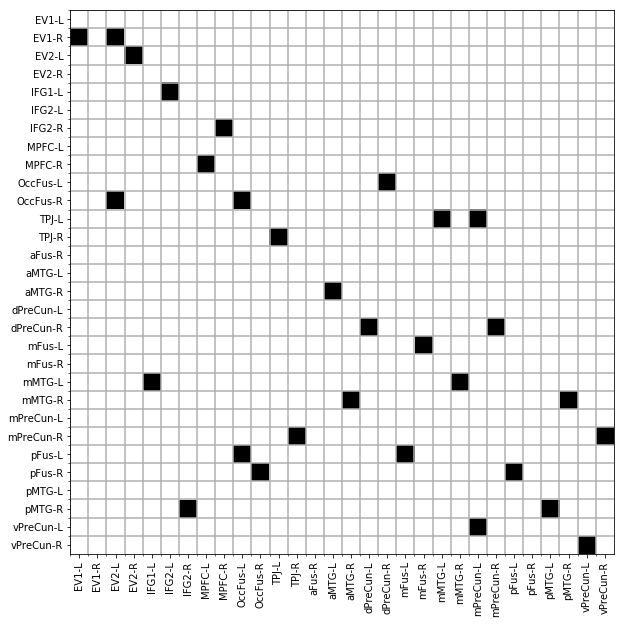

In [149]:
matrixplot = draw_adjacency_matrix(graph_nb, figsz=(10,10), node_order=sorted(graph_nb.nodes()))

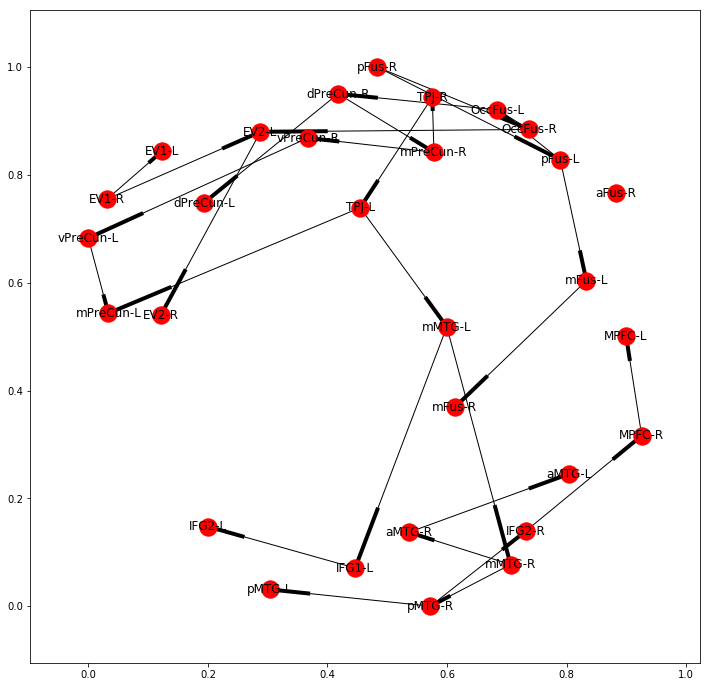

In [156]:
# use nx built in plotting method
positions=nx.spring_layout(graph_nb,iterations=30)
plt.figure(figsize=(12,12)) 
nx.draw_networkx(graph_nb, pos=positions)
plt.show()